# HBV hydrological model forced with ERA5 forcing data
In this notebook we will run the HBV model using the future CMIP6 forcing data we generated in earlier notebooks.

For a more basic explenation on how to run a model in eWaterCycle, see [this tutorial](https://www.ewatercycle.org/projects/main/tutorials_examples/1_HBV_Caravan_ERA5/example_model_run_HBV.html). 

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import json

# Niceties
from rich import print

In [2]:
# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [3]:
# Parameters
region_id = None
settings_path = "settings.json"

In [4]:
# Parameters
region_id = "camelsgb_23008"
settings_path = "regions/camelsgb_23008/settings.json"


In [5]:
# Load settings
# Read from the JSON file
with open(settings_path, "r") as json_file:
    settings = json.load(json_file)

## Generate or load forcing
The forcing loaded here was generated in [this notebook](step_1b_generate_future_forcing.ipynb).

In [6]:
# Load calibration constants from a csv file
par_0 = np.loadtxt(Path(settings["path_output"]) / (settings['caravan_id'] + "_params_SCE.csv"), delimiter = ",")

In [7]:
# Print parameter names and values
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
display(list(zip(param_names, np.round(par_0, decimals=3))))

[('Imax', 8.0),
 ('Ce', 1.0),
 ('Sumax', 40.0),
 ('Beta', 4.0),
 ('Pmax', 0.001),
 ('Tlag', 1.0),
 ('Kf', 0.1),
 ('Ks', 0.001),
 ('FM', 9.94)]

In [8]:
# Set initial state values
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

In [9]:
model_output = dict()

for dataset_name in settings['CMIP_info']['dataset']: 
    # We are asuming one dataset, but this loop allows for multiple
    display(dataset_name)

   
    for experiment_name in settings['CMIP_info']['experiments'][1:]: #skipping historical
        display(experiment_name)

    
        for ensemble_name in settings['CMIP_info']['ensembles']:
            display(ensemble_name)

            model_run_name = dataset_name + "," + experiment_name + "," + ensemble_name

            cmip_dataset = {
                "dataset": dataset_name,
                "project": settings['CMIP_info']['project'],
                "grid": "gn",
                "exp": experiment_name,
                "ensemble": ensemble_name,
            }
        
            # Create a subfolder for this specific combination of dataset, experiment and ensemblemember
            path_CMIP6 = Path(settings['path_CMIP6']) / cmip_dataset["dataset"] / cmip_dataset["exp"] / cmip_dataset["ensemble"]
            load_location = path_CMIP6 / "work" / "diagnostic" / "script" 
            CMIP_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

            model = ewatercycle.models.HBVLocal(forcing=CMIP_forcing_object)

            # Create config file in model.setup()
            config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)
            # Initialize model
            model.initialize(config_file)
            # Run model, capture calculated discharge and timestamps
            Q_m = []
            time = []
            while model.time < model.end_time:
                model.update()
                Q_m.append(model.get_value("Q")[0])
                time.append(pd.Timestamp(model.time_as_datetime))
            # Finalize model (shuts down container, frees memory)
            model.finalize()
        
            # Make a pandas series
            model_output[model_run_name] = pd.Series(data=Q_m, name="modelled discharge, forcing: " + model_run_name, index=time)

'MPI-ESM1-2-HR'

'ssp126'

'r1i1p1f1'

'ssp245'

'r1i1p1f1'

'ssp370'

'r1i1p1f1'

'ssp585'

'r1i1p1f1'

## Process results
Finally, we use standard python libraries to visualize the results. We put the model output into a pandas Series to make plotting easier.

In [10]:
# We want to also be able to use the output of this model run in different analyses. Therefore, we save it as a NetCDF file.
xr_model_output = xr.merge([model_output_per_model.to_xarray() for name, model_output_per_model in model_output.items()])
xr_model_output = xr_model_output.rename({'index': 'time'})
xr_model_output.attrs['units'] = 'mm/d'
display(xr_model_output)


<xarray.Dataset> Size: 307kB
Dimensions:                                                     (time: 7669)
Coordinates:
  * time                                                        (time) datetime64[ns] 61kB ...
Data variables:
    modelled discharge, forcing: MPI-ESM1-2-HR,ssp126,r1i1p1f1  (time) float64 61kB ...
    modelled discharge, forcing: MPI-ESM1-2-HR,ssp245,r1i1p1f1  (time) float64 61kB ...
    modelled discharge, forcing: MPI-ESM1-2-HR,ssp370,r1i1p1f1  (time) float64 61kB ...
    modelled discharge, forcing: MPI-ESM1-2-HR,ssp585,r1i1p1f1  (time) float64 61kB ...
Attributes:
    units:    mm/d

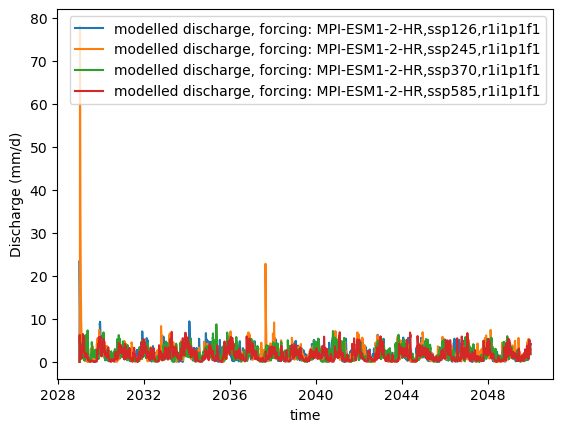

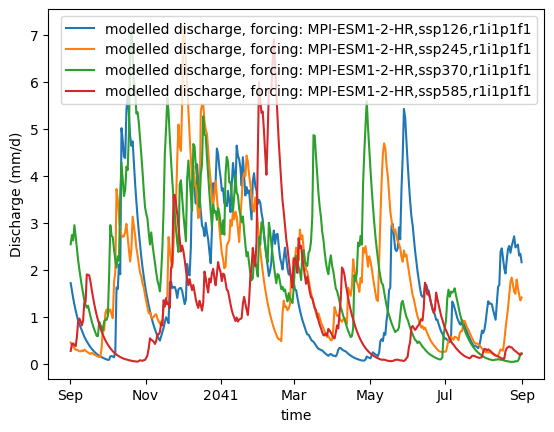

In [11]:
def plot_hydrograph(data_array):
    plt.figure()
    for var in data_array.data_vars:
        data_array[var].plot(label=var)
    plt.ylabel("Discharge (mm/d)")
    plt.legend()


xr_one_year = xr_model_output.sel(time=slice('2040-09-01', '2041-08-31'))

plot_hydrograph(xr_model_output)
plot_hydrograph(xr_one_year)

In [12]:
# Save the xarray Dataset to a NetCDF file
xr_model_output.to_netcdf(Path(settings['path_output']) / (settings['caravan_id'] + '_future_output.nc'))

In [13]:
# Remove all temporary directories made by the optimization algo.

!rm -rf hbvlocal*